# X-ray instrument response optimization

In this notebook I will discuss some ways to optimize folding a spectral-timing model through an instrument response. 

In [1]:
import sys
import os
import gc

import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import cm
from matplotlib.colors import TwoSlopeNorm
import matplotlib.gridspec as gridspec

from matplotlib import rc, rcParams
rc('text',usetex=True)
rc('font',**{'family':'serif','serif':['Computer Modern']})
fi = 22
plt.rcParams.update({'font.size': fi-5})

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from ndspec.Response import ResponseMatrix

rmfpath = os.getcwd()+"/data/nicer-rmf6s-teamonly-array50.rmf"
nicer_matrix = ResponseMatrix(rmfpath)
arfpath = os.getcwd()+"/data/nicer-consim135p-teamonly-array50.arf"
nicer_matrix.load_arf(arfpath)

Arf missing, please load it
Arf loaded


## Rebin the instrument response over channels

Taking tens of milliseconds to fold a model through a response matrix is comparable to (or even larger than) the computing time of a typical Xspec models. As a result, careless folding of the instrument response can be a major bottleneck in fitting modern, multi-dimensional data.

In practice however, one never needs 1500 channels when it comes to most X-ray data, particularly for the case of spectral-timing analysis. For instance, typical NICER timing products like lag spectra only use a few dozen energy bins, meaning we can rebin our instrument response to a grid of a few dozen channels instead. nDspec provides this functionality within the ```ResponseMatrix``` object.

Let us define an arbitrarily spaced new grid of 35 channel bounds. We can then rebin our matrix object with the ```rebin_channels``` method to this new, smaller grid made up of only 35 channels. After doing so, let us plot the response again, comparing channel and bounds once again:

/home/matteo/Software/nDspec/src/ndspec/Response.py:515: RuntimeWarning: divide by zero encountered in log10
  p = plt.pcolormesh(x_axis,energy_array,np.log10(self.resp_matrix),


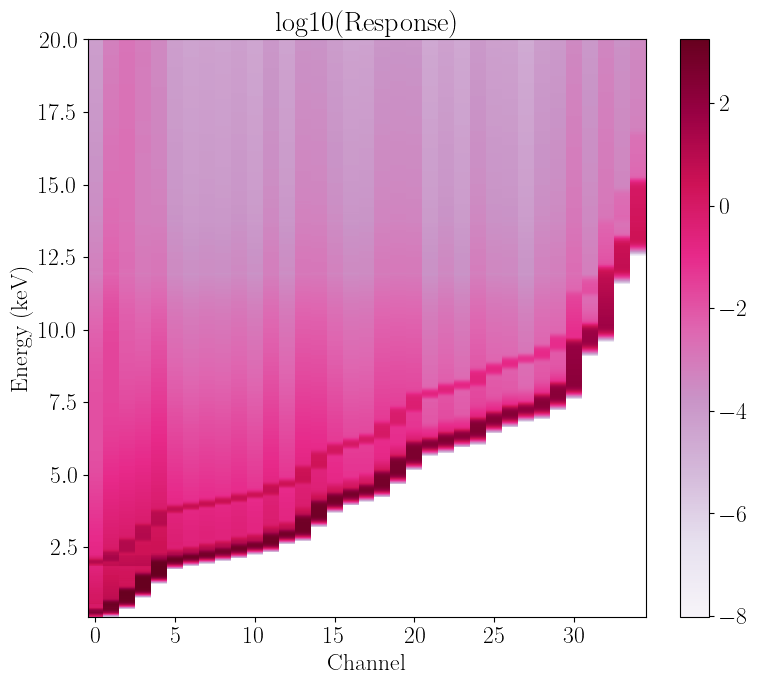

/home/matteo/Software/nDspec/src/ndspec/Response.py:515: RuntimeWarning: divide by zero encountered in log10
  p = plt.pcolormesh(x_axis,energy_array,np.log10(self.resp_matrix),


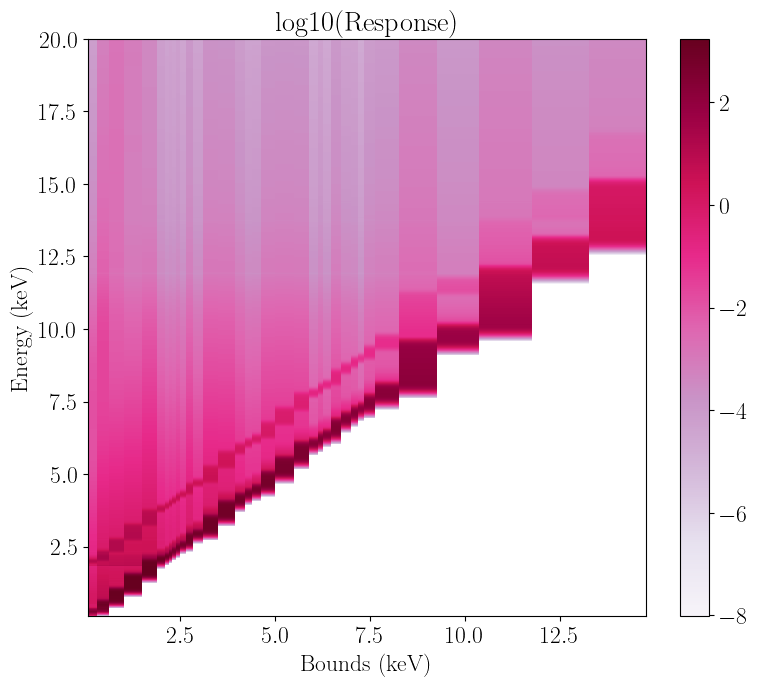

11356

In [2]:
#define an arbitrary grid, from arrays of lower and upper energy bounds
new_bounds_lo = np.array([0.1,0.3,0.6,1,1.5,2,2.13,2.21,2.3,2.4,2.52,2.6,2.9,3.,3.5,4.,4.25,
                          4.4,4.54,5,5.5,6,6.1,6.3,6.4,6.8,7,7.2,7.3,7.6,8,9.5,10.,12.,13.])
new_bounds_hi = np.array([0.3,0.6,1,1.5,2,2.13,2.21,2.3,2.4,2.52,2.6,2.9,3.,3.5,4.,4.25,4.4,
                          4.54,5,5.5,6,6.1,6.3,6.4,6.8,7,7.2,7.3,7.6,8,9.5,10.,12.,13.,15.])

#rebin the response matrix and plot the resulting new matrix
rebin_chans = nicer_matrix.rebin_channels(new_bounds_lo,new_bounds_hi)
rebin_chans.plot_response()
rebin_chans.plot_response(plot_type="energy")

gc.collect()

The response natrix is now much coarser, but for spectral-timing data this is not a problem. Let us now define a sample spectral model, using a blackbody with a temperature of 1 keV and unity normalization, convolve it with both instrument respones, and compare the two folded models. Note how the rebinned matrix produced a much coarser folded model, but otherwise the count rate over energy is roughly identical:

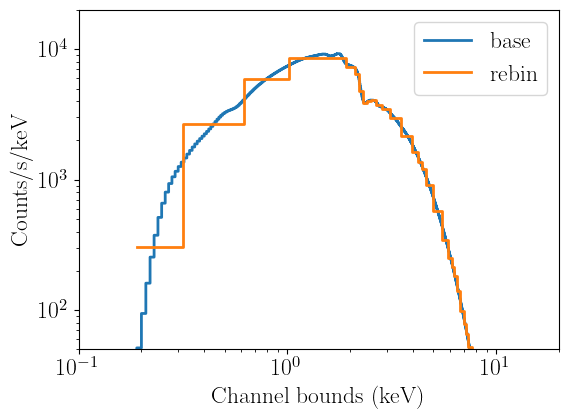

In [3]:
def bbody(array, params):
    #with these defintions, this model is identical to the xspec implementation
    norm = params[0]
    temp = params[1]
    renorm = 8.0525*norm/np.power(temp,4.)
    planck = np.exp(array/temp)-1.
    model = renorm*np.power(array,2.)/planck
    return model 

#define the energy bin mid points and widths, from the matrix we just loaded
nicer_grid = 0.5*(nicer_matrix.energ_hi+nicer_matrix.energ_lo)
nicer_bins = nicer_matrix.energ_hi-nicer_matrix.energ_lo

#define the model and convolve it with the response
bb_params = np.array([1.,1.])
bb_model = bbody(nicer_grid,bb_params)*nicer_bins
nobin_fold = nicer_matrix.convolve_response(bb_model,units_in="xspec",units_out="kev")
channel_grid = 0.5*(nicer_matrix.emax+nicer_matrix.emin)

rebin_channel_fold = rebin_chans.convolve_response(bb_model,units_in="xspec",units_out="kev")
rebin_grid = 0.5*(rebin_chans.emax+rebin_chans.emin)

fig, (ax1)  = plt.subplots(1,1,figsize=(6,4.5))

ax1.step(channel_grid,nobin_fold,label='base',lw=2,where='mid')
ax1.step(rebin_grid,rebin_channel_fold,label='rebin',lw=2,where='mid')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Channel bounds (keV)")
ax1.set_ylabel("Counts/s/keV")
ax1.legend(loc='upper right')
ax1.set_xlim([0.1,20.])
ax1.set_ylim([5e1,2e4])

fig.tight_layout()

Now we can benchmark the two convolutions and note that, as we would expect, the re-binned convolution is much faster:

In [4]:
from timeit import Timer

print("Unbinned convolution runtime:")
%timeit nicer_matrix.convolve_response(bb_model,units_in="xspec",units_out="kev")

print("Channel rebinning convolution runtime:")
%timeit rebin_chans.convolve_response(bb_model,units_in='xspec',units_out="kev")

Unbinned convolution runtime:
8.09 ms ± 427 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Channel rebinning convolution runtime:
16.1 µs ± 4.12 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In general, rebinning over channels prevents one from finding fine energy-dependent features in the data, which is almost never the goal with spectral-timing analysis. Therefore, this is the preferred rebinning method to speed up model computations.

## Rebin the instrument response over energy

Rather than over (arbitrary) instrument channels, it is also possible to rebin a response over physical photon energies. Rebinning to a coarser energy grid has the added bonus of speeding up the computation time of a model. However, rebinning to a coarse energy grid can introduce spurious features in the model (and therefore the residuals, once that model is compared to data), so it should generally be done with care if at all. 

Let us look at potential issues that might appear. First, the effective area can change noticeably when rebinning over energy. Let us show this by comparing the NICER arf, before and after interpolating it over a coarse energy grid:

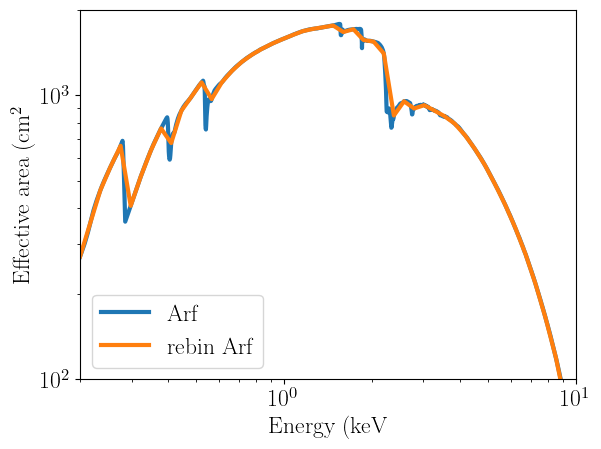

In [5]:
#define a coarse, geometrically spaced energy grid:
coarse_grid = np.geomspace(0.2,10.,50)

#interpolate over the nicer arf:
interp_obj = interp1d(nicer_grid,nicer_matrix.specresp)
interp_arf = interp_obj(coarse_grid)

##TBD REDO THIS WITH AX NOT THE PLT THINGY
plt.plot(nicer_grid,nicer_matrix.specresp,lw=3,label="Arf")
plt.plot(coarse_grid,interp_arf,lw=3,label="rebin Arf")
plt.xscale("log")
plt.yscale("log")
plt.ylim([1e2,2e3])
plt.xlim([0.2,10])    
plt.xlabel("Energy (keV")
plt.ylabel("Effective area (cm$^{2}$")
plt.legend(loc="lower left")

plt.show()

Note how the sharp features are all completely washed out by the interpolation over such a coarse. Rebinning over energy can have a similar effect, if done too aggressively. Let us show this explicitely by taking the NICER response, rebinning it in energy, and comparing the folded model to the unbinned case. 

In nDspec, a ```ResponseMatrix``` object can only be rebinned over energy by integer rebinning - that is, it is only possible to group a fixed number of energy bins together in a new matrix. This is done with the ```rebin_energy``` method, which takes as an input the integer factor desired by the user. Compared to allowing for an arbitrary grid this is much safer, as we do not have to deal with a new grid edges potentially not overlapping with the initial ones, and replicates the functionality in Heasoft. 

First, let us calculate the rebinned response for both a coarse and intermediate resolution energy grid, and compare the size of the arrays:

In [6]:
rebin_coarse = nicer_matrix.rebin_energies(50)
print("The rebinned energy with coarse resolution grid has a size:",rebin_coarse.energ_hi.shape)

rebin_inter = nicer_matrix.rebin_energies(10)
print("The rebinned energy with intermediate resolution grid has a size:",rebin_inter.energ_hi.shape)

/home/matteo/Software/nDspec/src/ndspec/Response.py:378: UserWarning: WARNING: rebinning a response in energy is dangerous, use at your own risk!
  warnings.warn("WARNING: rebinning a response in energy is dangerous, use at your own risk!",


The rebinned energy with coarse resolution grid has a size: (70,)
The rebinned energy with intermediate resolution grid has a size: (346,)


Let us now fold our black body model through these responses, and compare the results to the base matrix:

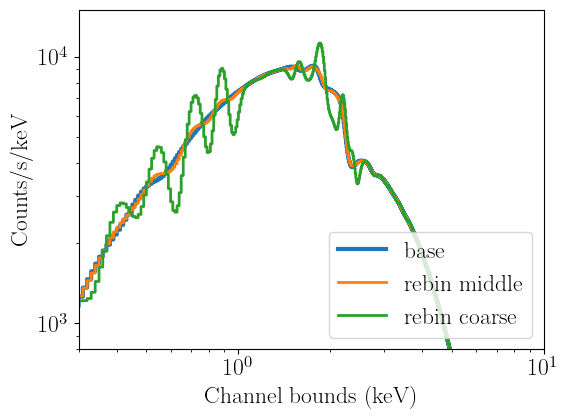

In [7]:
#define the energy bin mid points and widths, from the matrices we just calculated
inter_grid = 0.5*(rebin_inter.energ_hi+rebin_inter.energ_lo)
inter_bins = rebin_inter.energ_hi-rebin_inter.energ_lo

coarse_grid = 0.5*(rebin_coarse.energ_hi+rebin_coarse.energ_lo)
coarse_bins = rebin_coarse.energ_hi-rebin_coarse.energ_lo

#define the models and convolve them with the response
bb_inter = bbody(inter_grid,bb_params)*inter_bins
energy_inter_fold = rebin_inter.convolve_response(bb_inter,units_in="xspec",units_out="kev")

bb_coarse = bbody(coarse_grid,bb_params)*coarse_bins
energy_coarse_fold = rebin_coarse.convolve_response(bb_coarse,units_in="xspec",units_out="kev")

fig, (ax1)  = plt.subplots(1,1,figsize=(6,4.5))

ax1.step(channel_grid,nobin_fold,label='base',lw=3,where='mid')
ax1.step(channel_grid,energy_inter_fold,label='rebin middle',lw=2,where='mid')
ax1.step(channel_grid,energy_coarse_fold,label='rebin coarse',lw=2,where='mid')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Channel bounds (keV)")
ax1.set_ylabel("Counts/s/keV")
ax1.legend(loc='lower right')
ax1.set_xlim([0.3,10.])
ax1.set_ylim([8e2,1.5e4])

fig.tight_layout()

With our extremely coarse grid, we have gone from the 3451 energy bins in the default NICER matrix, to just 70. The result of folding a model through this response is the introduction of horrific features that are not present in the un-binned model, and are therefore not physical. This means our energy rebinning was much too aggressive, and is a textbook example of why energy rebinning can be dangerous.

The intermediate grid has 346 energy bins. In this case, some features are still introduced in the folded model, but they are much less noticeable than with the coarse grid. These may or may not appear as residuals depending on the data quality, so users still need to exercise caution.

Let us now look at what happens when we rebin in both channels and energy:

/home/matteo/Software/nDspec/src/ndspec/Response.py:378: UserWarning: WARNING: rebinning a response in energy is dangerous, use at your own risk!
  warnings.warn("WARNING: rebinning a response in energy is dangerous, use at your own risk!",


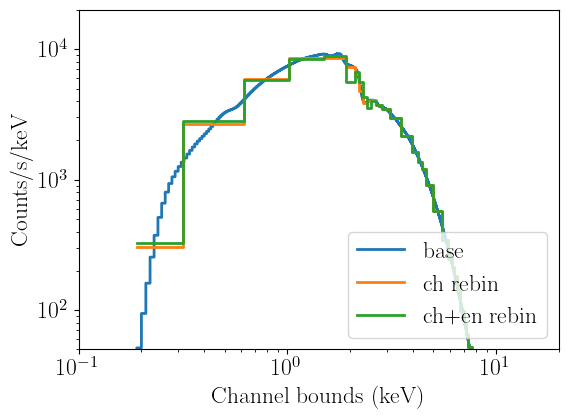

In [8]:
full_rebin = rebin_chans.rebin_energies(50)
full_rebin_fold = full_rebin.convolve_response(bb_coarse,units_in="xspec",units_out="kev")

fig, (ax1)  = plt.subplots(1,1,figsize=(6,4.5))

ax1.step(channel_grid,nobin_fold,label='base',lw=2,where='mid')
ax1.step(rebin_grid,rebin_channel_fold,label='ch rebin',lw=2,where='mid')
ax1.step(rebin_grid,full_rebin_fold,label='ch+en rebin',lw=2,where='mid')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Channel bounds (keV)")
ax1.set_ylabel("Counts/s/keV")
ax1.legend(loc='lower right')
ax1.set_xlim([0.1,20.])
ax1.set_ylim([5e1,2e4])

fig.tight_layout()

Even with very coarse channel bounds, the very coarse energy rebinning introduces unphysical features in the folded model. Once again, this shows that energy rebinnig, if done at all, should be done with care, particularly because the performance gain is much smaller than rebinning in channels: 

In [ ]:
print("Unbinned convolution runtime:")
%timeit nicer_matrix.convolve_response(bb_model,units_in="xspec",units_out="kev")

print("Channel rebinning convolution runtime:")
%timeit rebin_chans.convolve_response(bb_model,units_in='xspec',units_out="kev")

print("Intermediate energy rebinning convolution runtime")
%timeit rebin_inter.convolve_response(bb_inter,units_in="xspec",units_out="kev")

print("Coarse energy+channel rebinning convolution runtime")
%timeit full_rebin.convolve_response(bb_coarse,units_in="xspec",units_out="kev")

Unbinned convolution runtime:
8.3 ms ± 600 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Channel rebinning convolution runtime:


## Rebinning responses for two-dimensional models

The same considerations also hold for folding two-dimensional models. Let us show this by defining the same impulse response function as in the last tutorial, and then compare the effects of the coarser energy grid:

In [ ]:
#define our model functions:
def gaussian(array, params):
    center = params[0]
    width = params[1]
    norm = np.multiply(np.sqrt(2.0*np.pi),width)
    shape = np.exp(-np.power((array - center)/width,2.0)/2)
    line = shape/norm 
    return line

def powerlaw(array, params):
    norm = params[0]
    slope = params[1]
    model = norm*np.power(array,slope)
    return model

def gauss_fred(array1,array2,params):
    times = array1
    energy = array2
    norm = params[0]
    width = params[1]
    center = params[2]
    rise_t = params[3]
    decay_t = params[4]
    decay_w = params[5]
    sigma = width*powerlaw(times,np.array([1.,decay_w]))
    fred_profile = np.exp(np.nan_to_num(-rise_t/times)-np.nan_to_num(times/decay_t))
    fred_pulse = np.zeros((len(energy),len(times)))
    line_profile = np.zeros(len(energy))
    pulse_profile = np.zeros(len(times))
    for i in range(len(times)):
        fred_pulse[:,i] = gaussian(energy,np.array([center,sigma[i]]))*fred_profile[i]    
    line_profile = np.sum(fred_pulse,axis=1)
    pulse_profile = np.sum(fred_pulse,axis=0)
    return fred_pulse, line_profile, pulse_profile

#define a time grid and evaulaute the model defined earlier
time_res = 250
time_array = np.linspace(0.1,400,time_res)

norm = 1.
width = 2.5
center = 6.5
rise = 10.
decay = 60.
slope = -0.25

#first define a model with the base energy grid
impulse_base, line_profile_base, pulse_profile_base = gauss_fred(time_array,nicer_grid,[1.,2.5,6.0,10,60,-0.25])
#then do the same with the coarse energy grid
impulse_en_rebin, line_profile_en_rebin, pulse_profile_en_rebin = gauss_fred(time_array,coarse_grid,[1.,2.5,6.0,10,60,-0.25])

In [ ]:
rebinned_model = rebin_matrix.convolve_response(impulse_test)

rebinned_line_profile = np.zeros(rebin_matrix.n_chans)

new_bounds = 0.5*(rebin_matrix.emax+rebin_matrix.emin)

#because we rebinned the response, we need to re-calculate the line profile
for j in range(rebin_matrix.n_chans):
    rebinned_line_profile[j] = np.sum(rebinned_model[j,:])

fig = plt.figure(figsize=(9.,7.5))

gs = gridspec.GridSpec(200,200) 
gs.update(wspace=0,hspace=0)
ax = plt.subplot(gs[:-50,:-50])
side = plt.subplot(gs[:-50,-50:200])
below = plt.subplot(gs[-50:200,:-50])

ax.pcolormesh(time_array,rebin_matrix.chans,rebinned_model,cmap="PuRd",
              shading='auto',linewidth=0,rasterized=True)

ax.set_xticklabels([])
ax.set_xlim([0,400.])
ax.xaxis.set_visible(False)

below.semilogy(time_array,pulse_profile,linewidth=2.5,color=colorscale[3])
below.set_xlabel("Time ($\\rm{R_g}/c$)",fontsize=18)
below.set_ylabel("Response",fontsize=18)
below.set_xlim([0,400.])
below.set_ylim([1e-1,3e2])

side.plot(rebinned_line_profile,rebin_matrix.chans,linewidth=2.5,color=colorscale[3])
side.invert_xaxis()
side.yaxis.tick_right()
side.yaxis.set_label_position('right')
side.yaxis.set_ticks_position('both')
side.set_xlabel("Line profile \n (arb. units)",fontsize=18)
side.set_ylabel("Channel",fontsize=18)

ax.set_title("Detector space rebinned model")

plt.show()

gc.collect()

All this means is that converting from channel to energy (and vice versa) is no longer straighfroward. However, this is handled automatically by ```rebin_response```, which also adjusts the energy arrays stored in our ResponseMatrix object. 

We can take the newly defined energy bins defined above, and plot against these instead of channel number, to recover a more ''reasonable'' looking impulse response function. With these units, we see the same behavior as the full response earlier: the drop in effective area at high energy causes resultant shift of the peak of the line to below 5 keV, while the minor features at low channels have been smeared out and are even less noticeable:

In [ ]:
fig = plt.figure(figsize=(9.,7.5))

gs = gridspec.GridSpec(200,200) 
gs.update(wspace=0,hspace=0)
ax = plt.subplot(gs[:-50,:-50])
side = plt.subplot(gs[:-50,-50:200])
below = plt.subplot(gs[-50:200,:-50])

ax.pcolormesh(time_array,new_bounds,rebinned_model,cmap="PuRd",
              shading='auto',linewidth=0,rasterized=True)

ax.set_xticklabels([])
ax.set_xlim([0,400.])
ax.xaxis.set_visible(False)

below.semilogy(time_array,pulse_profile,linewidth=2.5,color=colorscale[3])
below.set_xlabel("Time ($\\rm{R_g}/c$)",fontsize=18)
below.set_ylabel("Response",fontsize=18)
below.set_xlim([0,400.])
below.set_ylim([1e-1,3e2])

side.plot(rebinned_line_profile,new_bounds,linewidth=2.5,color=colorscale[3])
side.invert_xaxis()
side.yaxis.tick_right()
side.yaxis.set_label_position('right')
side.yaxis.set_ticks_position('both')
side.set_xlabel("Line profile \n (arb. units)",fontsize=18)
side.set_ylabel("Energy (keV)",fontsize=18)

ax.set_title("Energy space rebinned model")

plt.show()

gc.collect()

And if we benchmark the convolution with the coarser response, we find that this operation is now far, far faster:

In [ ]:
%timeit rebin_matrix.convolve_response(impulse_test)

And we are down to about 1ms, a factor of 10 or more without any additional optimization such as just-in-time compilation and GPU acceleration!

In [ ]:
#visualize the high resolution model
colorscale = pl.cm.PuRd(np.linspace(0.,1.,5))

fig = plt.figure(figsize=(9.,7.5))

gs = gridspec.GridSpec(200,200) 
gs.update(wspace=0,hspace=0)
ax = plt.subplot(gs[:-50,:-50])
side = plt.subplot(gs[:-50,-50:200])
below = plt.subplot(gs[-50:200,:-50])

c = ax.pcolormesh(time_array,nicer_grid,impulse_base,cmap="PuRd",
                  shading='auto',linewidth=0,rasterized=True)
ax.set_xticklabels([])
ax.set_ylim([0.1,10.5])
ax.set_xlim([0,400])
ax.set_ylabel("Energy (keV)",fontsize=18)
ax.xaxis.set_visible(False)

below.semilogy(time_array,pulse_profile_base,linewidth=2.5,color=colorscale[3])
below.set_xlabel("Time ($\\rm{R_g}/c$)",fontsize=18)
below.set_ylabel("Response",fontsize=18)
below.set_ylim([1e-1,3e2])
below.set_xlim([0,400])

side.plot(line_profile_base,nicer_grid,linewidth=2.5,color=colorscale[3])
side.invert_xaxis()
side.yaxis.tick_right()
side.yaxis.set_label_position('right')
side.yaxis.set_ticks_position('both')
side.set_yticklabels([], minor=False)
side.set_xlabel("Line profile \n (arb. units)",fontsize=18)
side.set_ylim([0.1,10.5])

fig.colorbar(c, ax=side)

ax.set_title("Energy space model")

plt.show()

gc.collect()

In [ ]:
#and now the low resolution model
fig = plt.figure(figsize=(9.,7.5))

gs = gridspec.GridSpec(200,200) 
gs.update(wspace=0,hspace=0)
ax = plt.subplot(gs[:-50,:-50])
side = plt.subplot(gs[:-50,-50:200])
below = plt.subplot(gs[-50:200,:-50])

c = ax.pcolormesh(time_array,coarse_grid,impulse_en_rebin,cmap="PuRd",
                  shading='auto',linewidth=0,rasterized=True)
ax.set_xticklabels([])
ax.set_ylim([0.1,10.5])
ax.set_xlim([0,400])
ax.set_ylabel("Energy (keV)",fontsize=18)
ax.xaxis.set_visible(False)

below.semilogy(time_array,pulse_profile_en_rebin,linewidth=2.5,color=colorscale[3])
below.set_xlabel("Time ($\\rm{R_g}/c$)",fontsize=18)
below.set_ylabel("Response",fontsize=18)
below.set_ylim([1e-3,4e0])
below.set_xlim([0,400])

side.plot(line_profile_en_rebin,coarse_grid,linewidth=2.5,color=colorscale[3])
side.invert_xaxis()
side.yaxis.tick_right()
side.yaxis.set_label_position('right')
side.yaxis.set_ticks_position('both')
side.set_yticklabels([], minor=False)
side.set_xlabel("Line profile \n (arb. units)",fontsize=18)
side.set_ylim([0.1,10.5])

fig.colorbar(c, ax=side)

ax.set_title("Energy space model")

plt.show()

gc.collect()

We can now fold these two models with the rebinned respones defined above, and compare the output for each caes

In [ ]:
#now let us fold the models through all the rebinned responses, and compare the outputs:
nobin_fold = nicer_matrix.convolve_response(impulse_base,units_in="rate")
channel_fold = rebin_chans.convolve_response(impulse_base,units_in="rate")
energy_fold = rebin_coarse.convolve_response(impulse_en_rebin,units_in="rate")
both_fold = full_rebin.convolve_response(impulse_en_rebin,units_in="rate")

In [ ]:
#first: plot the unbinned model
convolved_line_profile = np.sum(nobin_fold,axis=1)

fig = plt.figure(figsize=(9.,7.5))

gs = gridspec.GridSpec(200,200) 
gs.update(wspace=0,hspace=0)
ax = plt.subplot(gs[:-50,:-50])
side = plt.subplot(gs[:-50,-50:200])
below = plt.subplot(gs[-50:200,:-50])

c = ax.pcolormesh(time_array,channel_grid,nobin_fold,cmap="PuRd",
                  shading='auto',linewidth=0,rasterized=True)
ax.set_xticklabels([])
ax.set_ylim([0.1,10.5])
ax.set_xlim([0,400])
ax.set_ylabel("Energy (keV)",fontsize=18)
ax.xaxis.set_visible(False)

below.semilogy(time_array,pulse_profile_base,linewidth=2.5,color=colorscale[3])
below.set_xlabel("Time ($\\rm{R_g}/c$)",fontsize=18)
below.set_ylabel("Response",fontsize=18)
below.set_ylim([1e-1,3e2])
below.set_xlim([0,400])

side.plot(convolved_line_profile,channel_grid,linewidth=2.5,color=colorscale[3])
side.invert_xaxis()
side.yaxis.tick_right()
side.yaxis.set_label_position('right')
side.yaxis.set_ticks_position('both')
side.set_yticklabels([], minor=False)
side.set_xlabel("Line profile \n (arb. units)",fontsize=18)
side.set_xscale("log")
side.set_ylim([0.1,10.5])
side.set_xlim([1e4,1])

fig.colorbar(c, ax=side)

ax.set_title("Detector space model")

plt.show()

gc.collect()

In [ ]:
#first: plot the channel-rebinned model
convolved_line_profile = np.sum(channel_fold,axis=1)

fig = plt.figure(figsize=(9.,7.5))

gs = gridspec.GridSpec(200,200) 
gs.update(wspace=0,hspace=0)
ax = plt.subplot(gs[:-50,:-50])
side = plt.subplot(gs[:-50,-50:200])
below = plt.subplot(gs[-50:200,:-50])

c = ax.pcolormesh(time_array,rebin_grid,channel_fold,cmap="PuRd",
                  shading='auto',linewidth=0,rasterized=True)
ax.set_xticklabels([])
ax.set_ylim([0.1,10.5])
ax.set_xlim([0,400])
ax.set_ylabel("Energy (keV)",fontsize=18)
ax.xaxis.set_visible(False)

below.semilogy(time_array,pulse_profile_base,linewidth=2.5,color=colorscale[3])
below.set_xlabel("Time ($\\rm{R_g}/c$)",fontsize=18)
below.set_ylabel("Response",fontsize=18)
below.set_ylim([1e-1,3e2])
below.set_xlim([0,400])

side.plot(convolved_line_profile,rebin_grid,linewidth=2.5,color=colorscale[3])
side.invert_xaxis()
side.yaxis.tick_right()
side.yaxis.set_label_position('right')
side.yaxis.set_ticks_position('both')
side.set_yticklabels([], minor=False)
side.set_xlabel("Line profile \n (arb. units)",fontsize=18)
side.set_xscale("log")
side.set_ylim([0.1,10.5])
side.set_xlim([1e4,1])

fig.colorbar(c, ax=side)

ax.set_title("Detector space model")

plt.show()

gc.collect()

Unsurprisingly, changing the a coarse channel grid causes the instrumental features that appear in the folded model to be less sharp, but they are still present.

In [ ]:
#first: plot the energy-rebinned model
convolved_line_profile = np.sum(energy_fold,axis=1)

fig = plt.figure(figsize=(9.,7.5))

gs = gridspec.GridSpec(200,200) 
gs.update(wspace=0,hspace=0)
ax = plt.subplot(gs[:-50,:-50])
side = plt.subplot(gs[:-50,-50:200])
below = plt.subplot(gs[-50:200,:-50])

c = ax.pcolormesh(time_array,channel_grid,energy_fold,cmap="PuRd",
                  shading='auto',linewidth=0,rasterized=True)
ax.set_xticklabels([])
ax.set_ylim([0.1,10.5])
ax.set_xlim([0,400])
ax.set_ylabel("Energy (keV)",fontsize=18)
ax.xaxis.set_visible(False)

below.semilogy(time_array,pulse_profile_base,linewidth=2.5,color=colorscale[3])
below.set_xlabel("Time ($\\rm{R_g}/c$)",fontsize=18)
below.set_ylabel("Response",fontsize=18)
below.set_ylim([1e-1,3e2])
below.set_xlim([0,400])

side.plot(convolved_line_profile,channel_grid,linewidth=2.5,color=colorscale[3])
side.invert_xaxis()
side.yaxis.tick_right()
side.yaxis.set_label_position('right')
side.yaxis.set_ticks_position('both')
side.set_yticklabels([], minor=False)
side.set_xlabel("Line profile \n (arb. units)",fontsize=18)
side.set_xscale("log")
side.set_ylim([0.1,10.5])
side.set_xlim([1e4,1])

fig.colorbar(c, ax=side)

ax.set_title("Detector space model")

plt.show()

gc.collect()

Once again, rebinning in energy causes issues for the folded model. Despite the theoretically fine channel grid we're using, we can clearly tell the effects of the coarse energy grid in the final output, and plotting the time-integrated model shows clear distortions from the initial input that would not be present with a correct instrument response.

In [ ]:
#finally, the channel+energy rebin mode
convolved_line_profile = np.sum(both_fold,axis=1)

fig = plt.figure(figsize=(9.,7.5))

gs = gridspec.GridSpec(200,200) 
gs.update(wspace=0,hspace=0)
ax = plt.subplot(gs[:-50,:-50])
side = plt.subplot(gs[:-50,-50:200])
below = plt.subplot(gs[-50:200,:-50])

c = ax.pcolormesh(time_array,rebin_grid,both_fold,cmap="PuRd",
                  shading='auto',linewidth=0,rasterized=True)
ax.set_xticklabels([])
ax.set_ylim([0.1,10.5])
ax.set_xlim([0,400])
ax.set_ylabel("Energy (keV)",fontsize=18)
ax.xaxis.set_visible(False)

below.semilogy(time_array,pulse_profile_base,linewidth=2.5,color=colorscale[3])
below.set_xlabel("Time ($\\rm{R_g}/c$)",fontsize=18)
below.set_ylabel("Response",fontsize=18)
below.set_ylim([1e-1,3e2])
below.set_xlim([0,400])

side.plot(convolved_line_profile,rebin_grid,linewidth=2.5,color=colorscale[3])
side.invert_xaxis()
side.yaxis.tick_right()
side.yaxis.set_label_position('right')
side.yaxis.set_ticks_position('both')
side.set_yticklabels([], minor=False)
side.set_xlabel("Line profile \n (arb. units)",fontsize=18)
side.set_xscale("log")
side.set_ylim([0.1,10.5])
side.set_xlim([1e4,1])

fig.colorbar(c, ax=side)

ax.set_title("Detector space model")

plt.show()

gc.collect()

Finally, folding with a response rebinned in both energy and channel to a coarse grid behaves somewhat similarly to the channel-rebinned response; however, the instrumental features appear slightly less defined in the line profile. This further reiterates that energy rebinning should be carried out very carefully. Finally, let us compare the performance in each case:

In [ ]:
print("Unbinned response fold time:")
%timeit nicer_matrix.convolve_response(impulse_base,units_in="rate")
print("Channel rebinned response fold time:")
%timeit rebin_chans.convolve_response(impulse_base,units_in="rate")
print("Energy rebinned response fold time:")
%timeit rebin_coarse.convolve_response(impulse_en_rebin,units_in="rate")
print("Channel+energy response fold time:")
%timeit full_rebin.convolve_response(impulse_en_rebin,units_in="rate")

Note that in this case energy rebinning does provide a major performance improvement, at the expense of model accuracy as discussed above.